# PyTorch Tutorials - Variational Autoencoder

In [13]:
import os

import numpy as np

import visdom
import matplotlib.pyplot as plt

import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util
from pyro.infer import SVI
from pyro.infer import Trace_ELBO
from pyro.optim import Adam

In [3]:
print(torch.__version__)
print(pyro.__version__)

pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(42)

smoke_test = 'CI' in os.environ

1.5.0+cpu
1.3.1


In [4]:
# load MNIST data
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = "./data"
    download = True
    trans = transforms.ToTensor()
    
    train_set = dset.MNIST(root=root, train=True, transform=trans,
                          download=download)
    test_set = dset.MNIST(root=root, train=False, transform=trans)
    
    kwargs = {'num_workers': 2, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                              batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size,
                                             shuffle=False, **kwargs)
    return train_loader, test_loader

In [5]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup lin.-transformations
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784)
        # setup non-linear
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, z):
        # define forward computation of latent z
        # compute hidden units
        hidden = self.softplus(self.fc1(z))
        # return the param for output Bernoulli
        # each with batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img
    

In [6]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup linear transformations
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup non-linear
        self.softplus = nn.Softplus()
    
    def forward(self, x):
        # define forward computation on the image x
        # first shape mini-batch to dimension
        x = x.reshape(-1, 784)
        # compute hidden units
        hidden = self.softplus(self.fc1(x))
        # return mean vector and positive square root covariance
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [7]:
class VAE(nn.Module):
    
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super().__init__()
        # init encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)
        
        if use_cuda:
            # load into GPU mem
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior (with GPU mem capability)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode latent z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))
            return loc_img

    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use encoder to get parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample latent z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            
    def reconstruct_img(self, x):
        """
        Helper function to reconstruct the image
        """
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image
        loc_img = self.decoder(z)
        return loc_img

In [8]:
def train(svi, train_loader, use_cuda=False):
    # init loss accumulator
    epoch_loss = 0
    # do training epoch over each mini-batch
    for x, _ in train_loader:
        if use_cuda: x = x.cuda()
        
        epoch_loss += svi.step(x)
    
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [9]:
def evaluate(svi, test_loader, use_cuda=False):
    # init loss accumulator
    test_loss = 0.
    # compute loss over entire test set
    for x, _ in test_loader:
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [11]:
LEARNING_RATE = 1.0e-3
USE_CUDA = False

# run single iteration
NUM_EPOCHS = 1 if smoke_test else 100
TEST_FREQUENCY = 5

[epoch 0] average train loss: 192.51230861816407


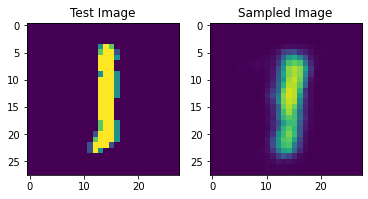

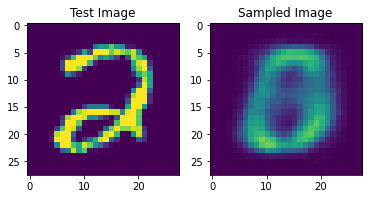

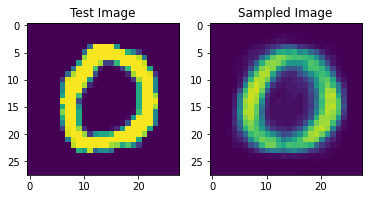

[epoch 0] average test loss: 156.89393212890624
[epoch 1] average train loss: 147.37060227050782
[epoch 2] average train loss: 133.61464055989583
[epoch 3] average train loss: 124.92502600097656
[epoch 4] average train loss: 119.32942905273437
[epoch 5] average train loss: 116.00943341471354


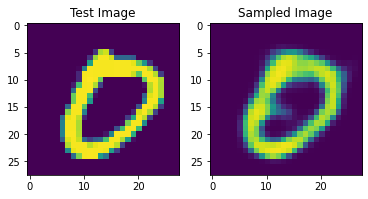

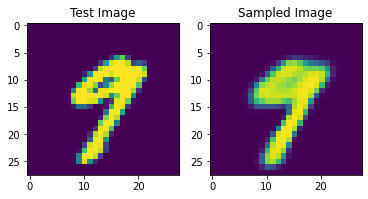

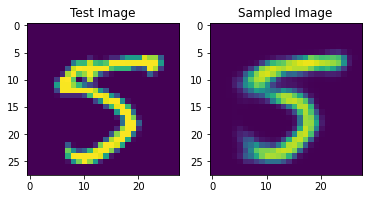

[epoch 5] average test loss: 113.95504618530273
[epoch 6] average train loss: 113.75540103352864
[epoch 7] average train loss: 112.13799887695312
[epoch 8] average train loss: 110.84659306640626
[epoch 9] average train loss: 109.80026031901042
[epoch 10] average train loss: 108.99114890136718


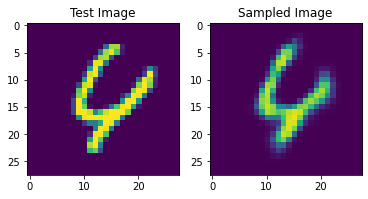

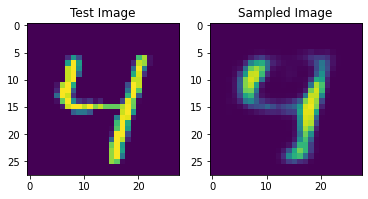

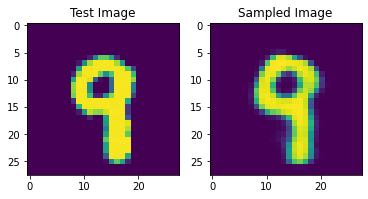

[epoch 10] average test loss: 108.05277205200196
[epoch 11] average train loss: 108.29571411132812
[epoch 12] average train loss: 107.7186862467448
[epoch 13] average train loss: 107.21692403971355
[epoch 14] average train loss: 106.83064110514323
[epoch 15] average train loss: 106.4814961751302


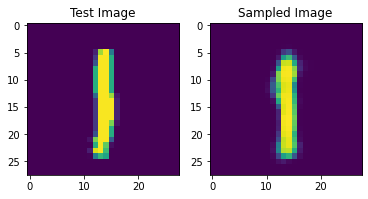

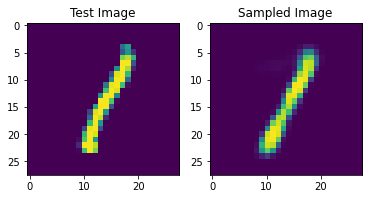

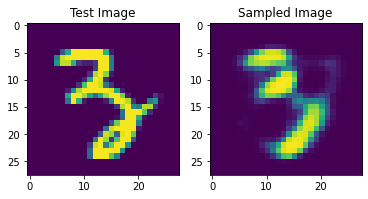

[epoch 15] average test loss: 105.81798977661133
[epoch 16] average train loss: 106.11512763671875
[epoch 17] average train loss: 105.85756703287761
[epoch 18] average train loss: 105.57753220214843
[epoch 19] average train loss: 105.37818627115885
[epoch 20] average train loss: 105.15074361165365


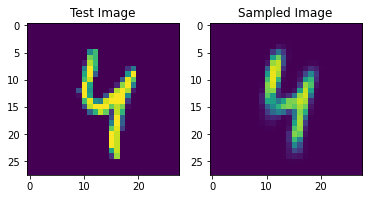

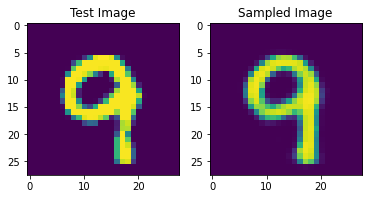

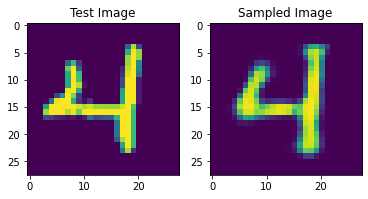

[epoch 20] average test loss: 104.8717923400879
[epoch 21] average train loss: 105.01370687662761
[epoch 22] average train loss: 104.823932421875
[epoch 23] average train loss: 104.68001834309896
[epoch 24] average train loss: 104.53421232910156
[epoch 25] average train loss: 104.4176502360026


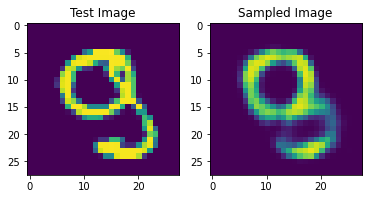

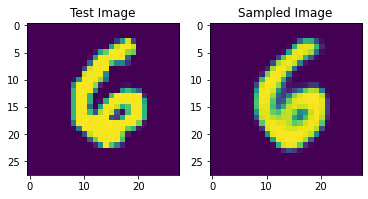

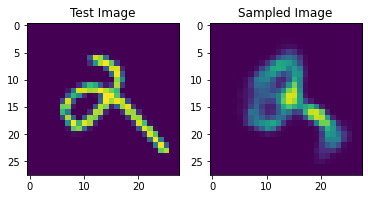

[epoch 25] average test loss: 104.02534673461913
[epoch 26] average train loss: 104.26830033365886
[epoch 27] average train loss: 104.14937608235677
[epoch 28] average train loss: 104.07333318684896
[epoch 29] average train loss: 103.90494899902343
[epoch 30] average train loss: 103.83620740559896


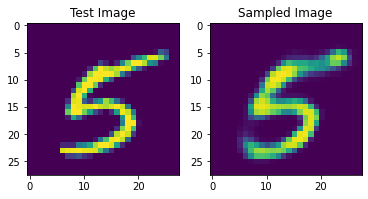

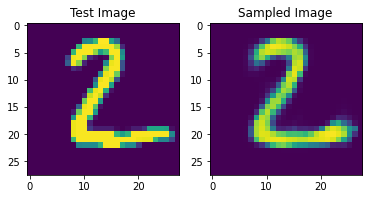

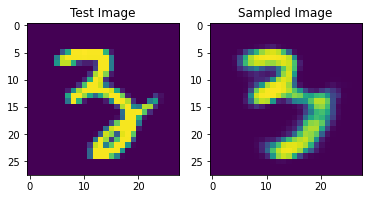

[epoch 30] average test loss: 103.86005177612304
[epoch 31] average train loss: 103.7501037923177
[epoch 32] average train loss: 103.67953403320313
[epoch 33] average train loss: 103.54702998046875
[epoch 34] average train loss: 103.49051359049479
[epoch 35] average train loss: 103.42085681966145


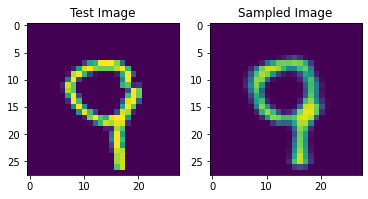

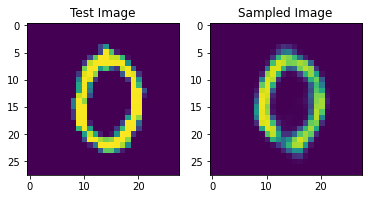

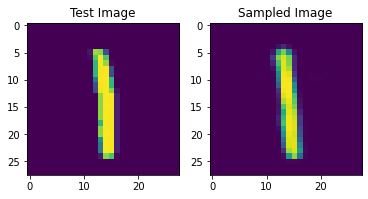

[epoch 35] average test loss: 103.44315629272461
[epoch 36] average train loss: 103.364442578125
[epoch 37] average train loss: 103.25019362792969
[epoch 38] average train loss: 103.18989357096355
[epoch 39] average train loss: 103.13324815266927
[epoch 40] average train loss: 103.08202681477864


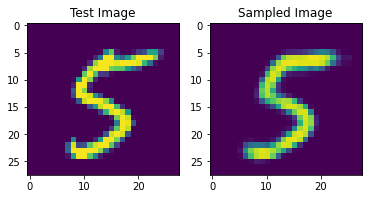

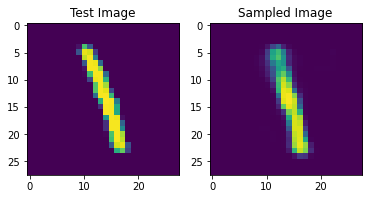

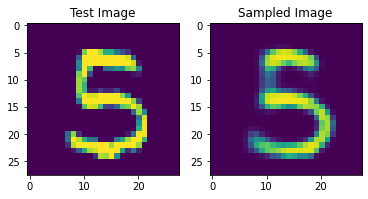

[epoch 40] average test loss: 102.98448276367188
[epoch 41] average train loss: 102.99675888671875
[epoch 42] average train loss: 102.95992749023438
[epoch 43] average train loss: 102.9236987874349
[epoch 44] average train loss: 102.8091796875
[epoch 45] average train loss: 102.80520589192709


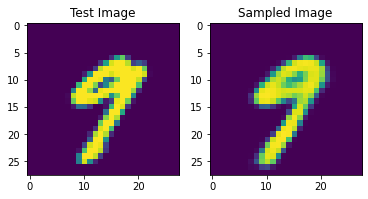

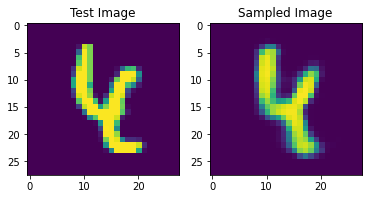

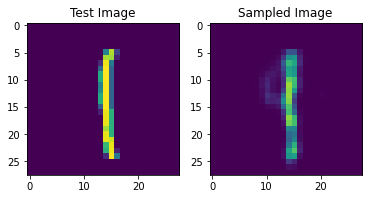

[epoch 45] average test loss: 102.86780895385742
[epoch 46] average train loss: 102.76077561035156
[epoch 47] average train loss: 102.68749047851563
[epoch 48] average train loss: 102.65677742513022
[epoch 49] average train loss: 102.58141974283855
[epoch 50] average train loss: 102.55771975911459


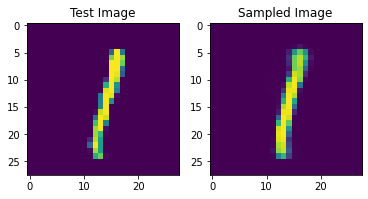

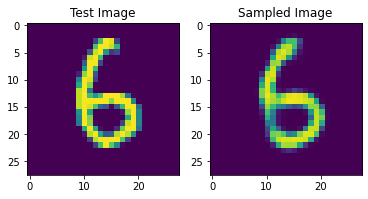

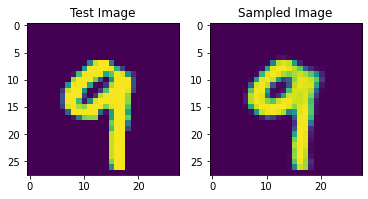

[epoch 50] average test loss: 102.44427738037109
[epoch 51] average train loss: 102.47408334960937
[epoch 52] average train loss: 102.469147265625
[epoch 53] average train loss: 102.43253264973958
[epoch 54] average train loss: 102.38048614908854
[epoch 55] average train loss: 102.34926883138021


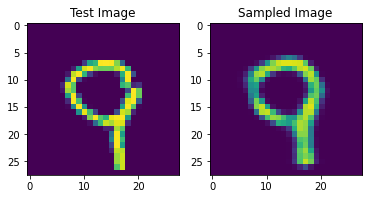

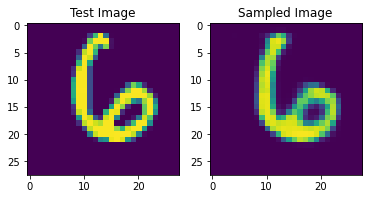

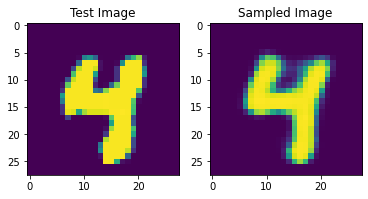

[epoch 55] average test loss: 102.22052889404297
[epoch 56] average train loss: 102.3061770263672
[epoch 57] average train loss: 102.25401485188802
[epoch 58] average train loss: 102.21633413085938
[epoch 59] average train loss: 102.16948958333333
[epoch 60] average train loss: 102.14108592122396


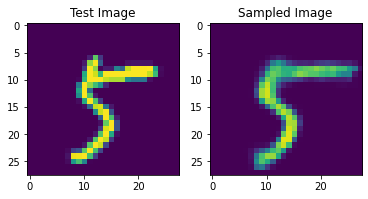

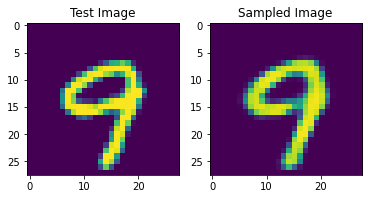

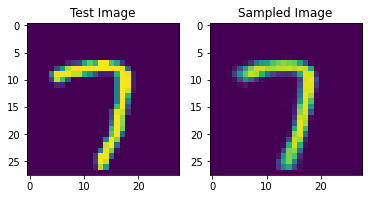

[epoch 60] average test loss: 102.13254467773437
[epoch 61] average train loss: 102.09998858235677
[epoch 62] average train loss: 102.06785981445313
[epoch 63] average train loss: 102.05996716308594
[epoch 64] average train loss: 101.99633885904947
[epoch 65] average train loss: 101.98038252766928


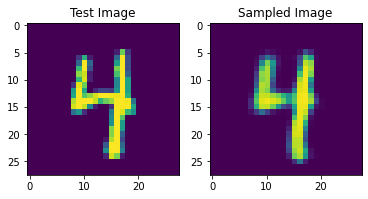

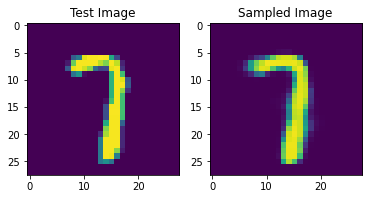

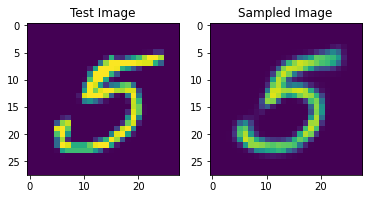

[epoch 65] average test loss: 102.10879800415039
[epoch 66] average train loss: 101.98036260579427
[epoch 67] average train loss: 101.90694130045573
[epoch 68] average train loss: 101.89441372070313
[epoch 69] average train loss: 101.8241963704427
[epoch 70] average train loss: 101.82728134765625


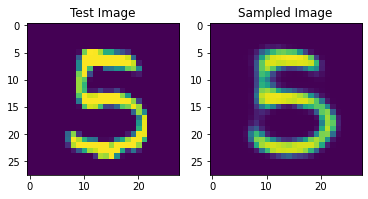

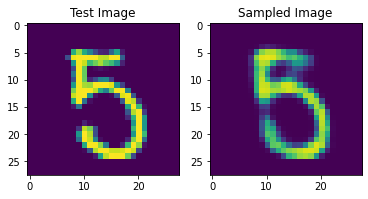

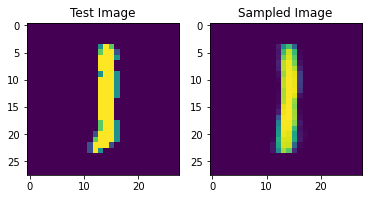

[epoch 70] average test loss: 101.82010522460938
[epoch 71] average train loss: 101.79660873209636
[epoch 72] average train loss: 101.75523181966146
[epoch 73] average train loss: 101.72421508789063
[epoch 74] average train loss: 101.72316327311198
[epoch 75] average train loss: 101.6616900797526


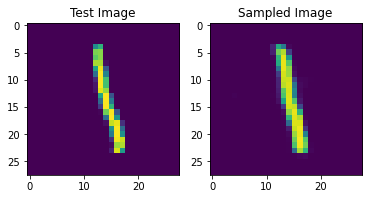

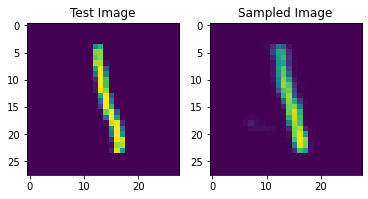

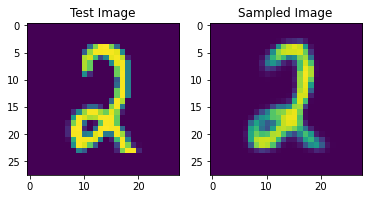

[epoch 75] average test loss: 101.9032088684082
[epoch 76] average train loss: 101.66937717285157
[epoch 77] average train loss: 101.58069867350261
[epoch 78] average train loss: 101.58737180175781
[epoch 79] average train loss: 101.53380614420573
[epoch 80] average train loss: 101.50899235026041


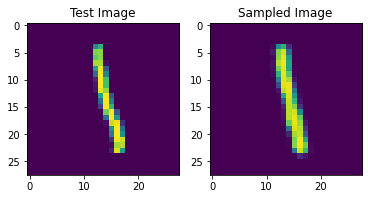

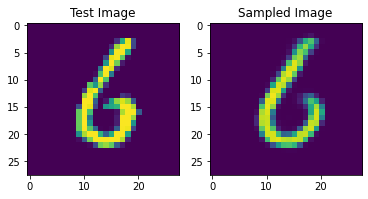

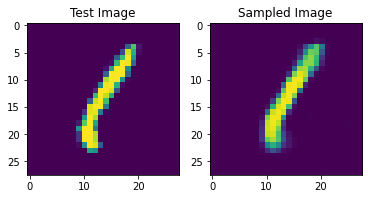

[epoch 80] average test loss: 101.70578344726563
[epoch 81] average train loss: 101.51668336588541
[epoch 82] average train loss: 101.49273154296876
[epoch 83] average train loss: 101.40940553385417
[epoch 84] average train loss: 101.42319864908855
[epoch 85] average train loss: 101.38140032552083


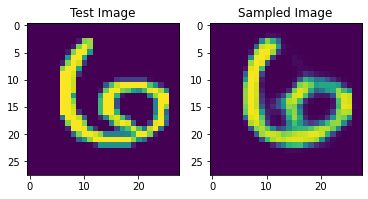

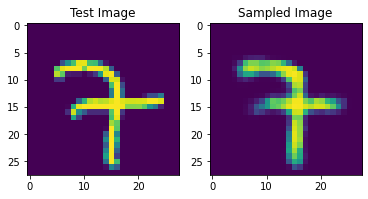

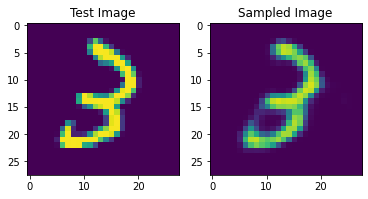

[epoch 85] average test loss: 101.71286982421876
[epoch 86] average train loss: 101.3654009358724
[epoch 87] average train loss: 101.3423398030599
[epoch 88] average train loss: 101.32408063151041
[epoch 89] average train loss: 101.29950808105468
[epoch 90] average train loss: 101.25183387044271


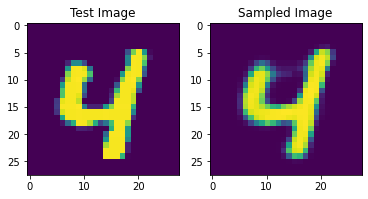

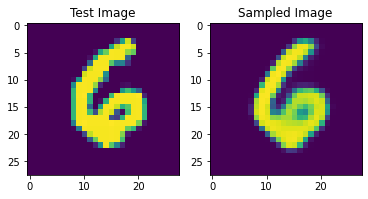

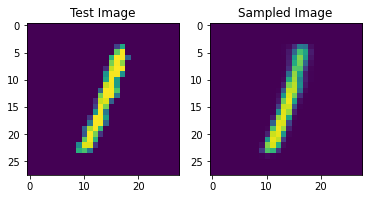

[epoch 90] average test loss: 101.46092128295898
[epoch 91] average train loss: 101.23910567220052
[epoch 92] average train loss: 101.18066522623698
[epoch 93] average train loss: 101.193542578125
[epoch 94] average train loss: 101.14501481119791
[epoch 95] average train loss: 101.11185442708333


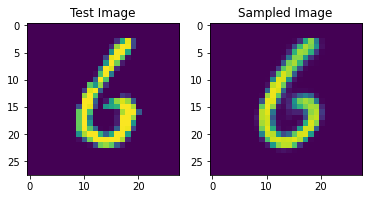

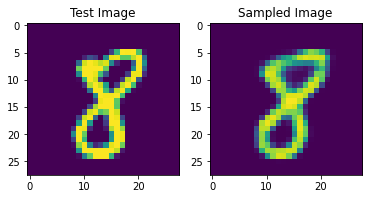

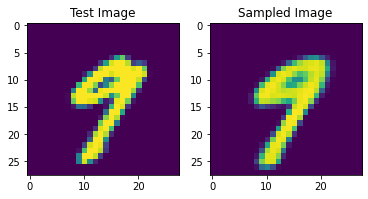

[epoch 95] average test loss: 101.40529022827148
[epoch 96] average train loss: 101.08984079589844
[epoch 97] average train loss: 101.0933597249349
[epoch 98] average train loss: 101.03367227376302
[epoch 99] average train loss: 101.00881657714844


In [19]:
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)
#vis = visdom.Visdom()

# clear param store
pyro.clear_param_store()

vae = VAE(use_cuda=USE_CUDA)

adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []

for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch {}] average train loss: {}".format(epoch, total_epoch_loss_train))
    
    if epoch % TEST_FREQUENCY == 0:
        test_loss = 0
        for i, (x, _) in enumerate(test_loader):
            test_loss += svi.evaluate_loss(x)
            
            # visualize in first iteration
            if i == 0:
                reco_indices = np.random.randint(0, x.shape[0], 3)
                for index in reco_indices:
                    test_img = x[index, :]
                    reco_img = vae.reconstruct_img(test_img)
                    
                    fig, ax = plt.subplots(1, 2)
                    ax[0].imshow(test_img.reshape(28, 28).detach().cpu().numpy(), vmin=0, vmax=1)
                    ax[0].set_title("Test Image")
                    ax[1].imshow(reco_img.reshape(28, 28).detach().cpu().numpy(), vmin=0, vmax=1)
                    ax[1].set_title("Sampled Image")
                    plt.show()
                    
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        # total test loss could be caluclated by added test loss / len(test_loader)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch {}] average test loss: {}".format(epoch, total_epoch_loss_test))